In [1]:
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms
from LPIPS import LPIPS
from ImageProcessor import ImageProcessor
from NST import NST
import warnings
import time
warnings.filterwarnings("ignore")
import copy

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
#code based on https://github.com/irasin/Pytorch_WCT
class WCT(NST):
    def __init__(self, content_path, style_paths, prebuild_encoder = None, prebuild_decoder = None):
        super().__init__(content_path, style_paths, prebuild_encoder, prebuild_decoder)
        self.encoder = self.normalised_vgg().eval()
        self.e1 = None
        self.e2 = None
        self.e3 = None
        self.e4 = None
        self.e5 = None
        self.decoder = self.vgg_decoder().eval()
        self.d1 = nn.Sequential(*copy.deepcopy(list(self.decoder.children())[-2:]))
        self.d2 = nn.Sequential(*copy.deepcopy(list(self.decoder.children())[-9:]))
        self.d3 = nn.Sequential(*copy.deepcopy(list(self.decoder.children())[-16:]))
        self.d4 = nn.Sequential(*copy.deepcopy(list(self.decoder.children())[-29:]))
        self.d5 = self.decoder 
        self.decoders = [self.d1,self.d2,self.d3,self.d4,self.d5] 
        
    class Interpolate(nn.Module):
        def __init__(self, scale_factor=2):
            super().__init__()
            self.scale_factor = scale_factor
    
        def forward(self, x):
            x = nn.functional.interpolate(x, scale_factor=self.scale_factor)
            return x

    
    def whiten_and_color(self, content_feature, style_feature, alpha=1):
        """
        A WCT function can be used directly between encoder and decoder
        """
        cf = content_feature.squeeze(0)#.double()
        c, ch, cw = cf.shape
        cf = cf.reshape(c, -1)
        c_mean = torch.mean(cf, 1, keepdim=True)
        cf = cf - c_mean
        c_cov = torch.mm(cf, cf.t()).div(ch*cw - 1)
        c_u, c_e, c_v = torch.svd(c_cov)
    
        # if necessary, use k-th largest eig-value
        k_c = c
        for i in range(c):
            if c_e[i] < 0.00001:
                k_c = i
                break
        c_d = c_e[:k_c].pow(-0.5)
    
        w_step1 = torch.mm(c_v[:, :k_c], torch.diag(c_d))
        w_step2 = torch.mm(w_step1, (c_v[:, :k_c].t()))
        whitened = torch.mm(w_step2, cf)
    
        sf = style_feature.squeeze(0)#.double()
        c, sh, sw = sf.shape
        sf = sf.reshape(c, -1)
        s_mean = torch.mean(sf, 1, keepdim=True)
        sf = sf - s_mean
        s_cov = torch.mm(sf, sf.t()).div(sh*sw -1)
        s_u, s_e, s_v = torch.svd(s_cov)
    
        # if necessary, use k-th largest eig-value
        k_s = c
        for i in range(c):
            if s_e[i] < 0.00001:
                k_s = i
                break
        s_d = s_e[:k_s].pow(0.5)
        c_step1 = torch.mm(s_v[:, :k_s], torch.diag(s_d))
        c_step2 = torch.mm(c_step1, s_v[:, :k_s].t())
        colored = torch.mm(c_step2, whitened) + s_mean
    
        colored_feature = colored.reshape(c, ch, cw).unsqueeze(0).float()
    
        colored_feature = alpha * colored_feature + (1.0 - alpha) * content_feature
        return colored_feature

    def normalised_vgg(self) :
        return nn.Sequential(
        	nn.Conv2d(3, 3, 1),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(3, 64, 3),
        	nn.ReLU(),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(64, 64, 3),
        	nn.ReLU(),
        	nn.MaxPool2d(2, ceil_mode=True),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(64, 128, 3),
        	nn.ReLU(),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(128, 128, 3),
        	nn.ReLU(),
        	nn.MaxPool2d(2, ceil_mode=True),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(128, 256, 3),
        	nn.ReLU(),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(256, 256, 3),
        	nn.ReLU(),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(256, 256, 3),
        	nn.ReLU(),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(256, 256, 3),
        	nn.ReLU(),
        	nn.MaxPool2d(2, ceil_mode=True),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(256, 512, 3),
        	nn.ReLU(),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(512, 512, 3),
        	nn.ReLU(),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(512, 512, 3),
        	nn.ReLU(),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(512, 512, 3),
        	nn.ReLU(),
        	nn.MaxPool2d(2, ceil_mode=True),
        	nn.ReflectionPad2d((1, 1, 1, 1)),
        	nn.Conv2d(512, 512, 3),
        	nn.ReLU()
        	)
        
    def vgg_decoder(self): 
        return nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
            self.Interpolate(2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(),
            self.Interpolate(2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(),
            self.Interpolate(2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(),
            self.Interpolate(2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(64, 3, 3)
            )
        
    #Load prebuild model
    def loadPrebuildEncoder(self):
        eState = torch.load(self.prebuild_encoder, map_location="cpu")
        self.encoder.load_state_dict(eState)
        self.e1 = nn.Sequential(*list(self.encoder.children())[:4])
        self.e2 = nn.Sequential(*list(self.encoder.children())[:11])
        self.e3 = nn.Sequential(*list(self.encoder.children())[:18])
        self.e4 = nn.Sequential(*list(self.encoder.children())[:31])
        self.e5 = self.encoder

    def loadPrebuildDecoder(self):
        for i in range(len(self.prebuild_decoder)):
            eState = torch.load(self.prebuild_decoder[i], map_location="cpu")
            self.decoders[i].load_state_dict(eState)

    def pipeline(self, alpha=1.0):
        content = self.content.tensorisedImage(1)
        style = self.styles[0].tensorisedImage(1)

        self.start = time.perf_counter()

        # #Layer 5
        c5 = self.e5(content)
        s5 = self.e5(style)
        cs5 = self.whiten_and_color(c5, s5, alpha)
        img = self.d5(cs5)

        #Layer 4
        c4 = self.e4(img)
        s4 = self.e4(style)
        cs4 = self.whiten_and_color(c4, s4, alpha)
        img = self.d4(cs4)

        #Layer 3
        c3 = self.e3(img)
        s3 = self.e3(style)
        cs3 = self.whiten_and_color(c3, s3, alpha)
        img = self.d3(cs3)

        #Layer 2
        c2 = self.e2(img)
        s2 = self.e2(style)
        cs2 = self.whiten_and_color(c2, s2, alpha)
        img = self.d2(cs2)

        #Layer 1
        c1 = self.e1(img)
        s1 = self.e1(style)
        cs1 = self.whiten_and_color(c1, s1, alpha)
        img = self.d1(cs1)

        self.end = time.perf_counter()

        self.stylisedTensor = img.detach().clamp(0, 1)
        self.stylisedImage = self.stylisedTensor.squeeze(0).permute(1,2,0).numpy()

        return self.stylisedImage

In [3]:
image_path = "content/avril.jpg"
style_path = "style/sketch.png"

prebuildDecoder = ["WCTModel/decoder_relu1_1.pth", "WCTModel/decoder_relu2_1.pth", "WCTModel/decoder_relu3_1.pth","WCTModel/decoder_relu4_1.pth", "WCTModel/decoder_relu5_1.pth"]
prebuildEncoder = "WCTModel/vgg_normalised_conv5_1.pth"

nstModel = WCT(image_path, [style_path],prebuildEncoder,prebuildDecoder)
nstModel.loadPrebuildEncoder()
nstModel.loadPrebuildDecoder()

In [4]:
nstModel.processor()
nstModel.pipeline(0.5)

array([[[0.15086794, 0.16310431, 0.16239676],
        [0.14849406, 0.15520409, 0.1550152 ],
        [0.15726468, 0.16336739, 0.14904355],
        ...,
        [0.750085  , 0.7638398 , 0.756937  ],
        [0.76515144, 0.7489716 , 0.7543637 ],
        [0.7652772 , 0.78015506, 0.75128216]],

       [[0.16179627, 0.14549494, 0.15392835],
        [0.14384335, 0.15879987, 0.1482476 ],
        [0.15259399, 0.14947073, 0.16134977],
        ...,
        [0.7574665 , 0.746737  , 0.7297546 ],
        [0.7548748 , 0.7497066 , 0.7507928 ],
        [0.76976675, 0.7364882 , 0.7379911 ]],

       [[0.14102936, 0.15316881, 0.1584736 ],
        [0.15521805, 0.15325011, 0.15587176],
        [0.16207395, 0.14828369, 0.14855757],
        ...,
        [0.74945444, 0.75590503, 0.7279004 ],
        [0.7546951 , 0.7395064 , 0.72700316],
        [0.75916576, 0.76457685, 0.7379961 ]],

       ...,

       [[0.5549199 , 0.5174524 , 0.5681193 ],
        [0.52962023, 0.5526439 , 0.65396374],
        [0.5479726 , 0

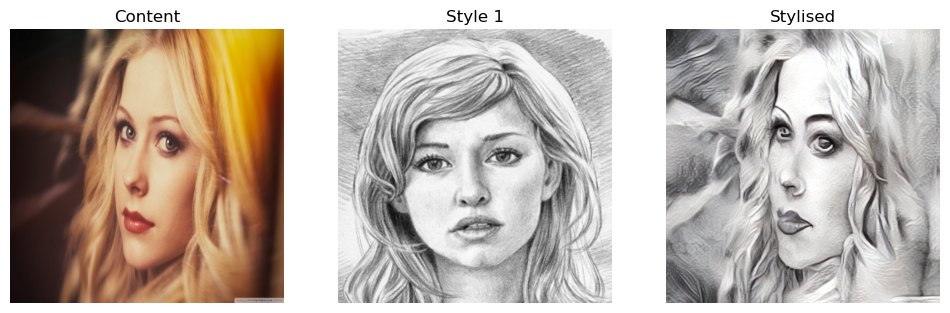

In [5]:
nstModel.displayImages()

In [6]:
nstModel.evaluate()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


(0.692, '15652.648 ms')